# Notes on Chapter 11 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow*, 3rd edition, by Aurélien Géron

Reduce the amount of logging messages displayed by TensorFlow

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [75]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

It's important to choose a reasonable initialization of weights that won't lead to explosion of gradients in either the forward or backpropagation steps.

In general, Glorot initialization ($\sigma^2 = 1/n_{\textrm{avg}}$) should be used for identity/sigmoid/softmax/tanh activation functions, He initialization ($\sigma^2 = 2/n_{\textrm{in}}$) for ReLU derivatives, and LeCun initialization ($\sigma^2 = 1/n_{\textrm{in}}$) for SELU.

In keras, layer initialization can be specified when creating the layer, e.g.

In [3]:
layer1 = tf.keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal")

It's also easy to set a custom variance scaling method, e.g.

In [4]:
my_initializer = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
layer2 = tf.keras.layers.Dense(64, activation="leaky_relu", kernel_initializer=my_initializer)

Multiple activation functions are available; the author recommends `relu` or `leaky_relu` for shallow networks, and `swish` ($z \sigma(\beta z)$) for deep networks.

Batch normalization is another approach, i.e.

$$
z_{ij} = \gamma_j \frac{ x_{ij} - \bar x_j }{\sqrt{\sigma_j^2 + \epsilon}} + \beta_j
$$

where $\bar x$ is the vector mean of $x$ (estimated over the batch or as a running average), $\sigma_j$ is the (estimated) variance of $x_{ij}$ for a fixed $j$ (i.e. $\Sigma_{jj}$ if $\Sigma$ is the covariance matrix of $x$), $\epsilon$ is a smoothing constant (typically $10^{-5}$), and $\gamma$ and $\beta$ are (learnable) parameters.

Typically training will be slower per epoc due to the extra computation, but convergence will be faster leading to shorter overall training times. Adding batch normalization is as easy as just adding another layer (typically before or after each hidden layer's activation function:

In [5]:
layer3 = tf.keras.layers.BatchNormalization()

It appears that there are ~4 parameters per input (estimates of $\bar x$ and $\sigma$ for each input and $\gamma$ and $\beta$ parameters).

In [6]:
m = tf.keras.Sequential([
    tf.keras.layers.Dense(5, input_shape=(5,), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),   
])
m.summary()
[(param.name, param.trainable) for param in m.layers[0].variables]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 batch_normalization_1 (Bat  (None, 5)                 20        
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 3)                 18        
                                                                 
 batch_normalization_2 (Bat  (None, 3)                 12        
 chNormalization)                                                
                                                                 
Total params: 80 (320.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 16 (64.00 Byte)
_________________________________________________________________


[('dense_2/kernel:0', True), ('dense_2/bias:0', True)]

There is debate about whether to add batch normalization after (as shown above) or before the activation function, but we can skip a redundant offset if we add it before the activation function: 

In [7]:
m = tf.keras.Sequential([
    tf.keras.layers.Dense(5, input_shape=(5,), kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(3, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.BatchNormalization(),   
])
m.summary()
[(param.name, param.trainable) for param in m.layers[0].variables]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 5)                 25        
                                                                 
 batch_normalization_3 (Bat  (None, 5)                 20        
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 5)                 0         
                                                                 
 dense_5 (Dense)             (None, 3)                 15        
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
 batch_normalization_4 (Bat  (None, 3)                 12        
 chNormalization)                                     

[('dense_4/kernel:0', True)]

Two important parameters for batch normalization are `momentum` (i.e. the smoothing factor for the exponential weighted average) and `axis` (which defaults to -1, meaning the last axis in the typical (batch size, features) shape). For a convolutional network, batch normalization would typically be done across channels (rather than a spacial axis).

In some cases (e.g. recurrent neural networks) batch normalization can be difficult, in which case gradient clipping can be used to mitigate the effects of exploding gradients:

In [8]:
optimizer = tf.keras.optimizers.Adam(clipvalue=0.9)
m.compile(optimizer=optimizer)

### Transfer learning

We'll work through an example from the book about transfer learning using the Fashion MNIST dataset. First we load the dataset and rescale the data from [0, 255] to [0.,1.]:

In [87]:
(X_fashion_train, y_fashion_train), (X_fashion_test, y_fashion_test) = tf.keras.datasets.fashion_mnist.load_data()
fashion_class_names = ["T-shirt/top", "trouser", "pullover", "dress", 
                       "coat", "sandal", "shirt", "sneaker", "bag",
                       "ankle boot"]
X_fashion_train = X_fashion_train / 255
X_fashion_test = X_fashion_test / 255

Let's assume there is a standard dataset with everything but T-shirt/tops and shirts:

In [167]:
mask_old_fashion_train = (
        y_fashion_train != fashion_class_names.index("T-shirt/top")
    ) & (
        y_fashion_train != fashion_class_names.index("shirt")
    )
mask_old_fashion_train[:2000] = False
X_old_fashion_train = X_fashion_train[mask_old_fashion_train]
y_old_fashion_train = y_fashion_train[mask_old_fashion_train]

In [168]:
tf.random.set_seed(42)
m_old_fashion = tf.keras.Sequential([
    layers.Input(shape=(28,28)),
    layers.Reshape((28,28,1)),
    layers.Conv2D(8, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(16, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(32, kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.Dense(len(fashion_class_names)),
    layers.Activation('softmax'),
])

In [169]:
m_old_fashion.compile(loss="sparse_categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
history = m_old_fashion.fit(X_old_fashion_train, y_old_fashion_train, 
    batch_size=128, epochs=8, validation_split=0.1, verbose=0)

(0.0, 1.0)

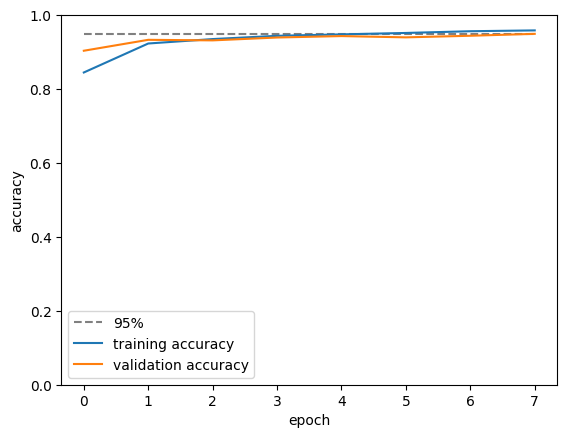

In [171]:
plt.hlines(0.95, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="95%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

Let's also assume we have a much smaller dataset that is designed to detect T-shirts/tops among shirts:

In [172]:
mask_new_fashion_train = (
        y_fashion_train == fashion_class_names.index("T-shirt/top")
    ) | (
        y_fashion_train == fashion_class_names.index("shirt")
    )
mask_old_fashion_train[2000:] = False
X_new_fashion_train = X_fashion_train[mask_new_fashion_train][:200]
y_new_fashion_train = (
        y_fashion_train == fashion_class_names.index("T-shirt/top")
    )[mask_new_fashion_train][:200]

We first try to naively train a model on our new, smaller dataset:

In [176]:
tf.random.set_seed(42)
m_new_fashion = tf.keras.Sequential([
    layers.Input(shape=(28,28)),
    layers.Reshape((28,28,1)),
    layers.Conv2D(8, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(16, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(32, kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.Dense(1),
    layers.Activation('sigmoid'),
])

In [177]:
m_new_fashion.compile(loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
history = m_new_fashion.fit(X_new_fashion_train, y_new_fashion_train, 
    batch_size=128, epochs=30, validation_split=0.3, verbose=0)

(0.0, 1.0)

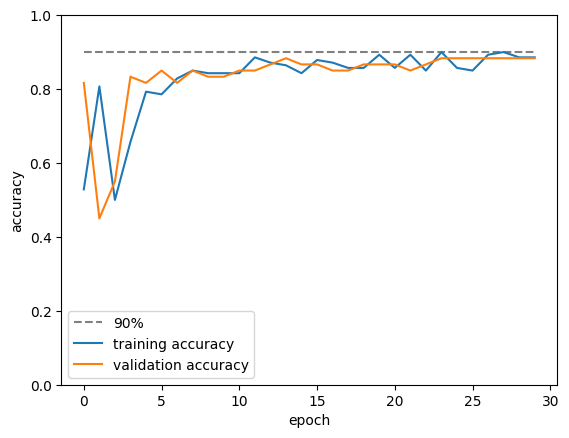

In [178]:
plt.hlines(0.9, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="90%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

Alternatively we could try using transfer learning from the old model:

In [213]:
m_old_fashion_clone = keras.models.clone_model(m_old_fashion)
m_old_fashion_clone.set_weights(m_old_fashion.get_weights())
m_new_old_fashion = keras.Sequential(m_old_fashion_clone.layers[:-4])
m_new_old_fashion.add(layers.Dense(32, kernel_initializer="he_uniform"))
m_new_old_fashion.add(layers.Activation('leaky_relu'))
m_new_old_fashion.add(layers.Dense(1))
m_new_old_fashion.add(layers.Activation('sigmoid'))

We first train the model with the transferred layers frozen.

In [227]:
for layer in m_new_old_fashion.layers[:-4]:
    layer.trainable = False

In [228]:
m_new_old_fashion.compile(loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=["accuracy"])
history = m_new_old_fashion.fit(X_new_fashion_train, y_new_fashion_train, 
    batch_size=128, epochs=10, validation_split=0.3, verbose=0)

(0.0, 1.0)

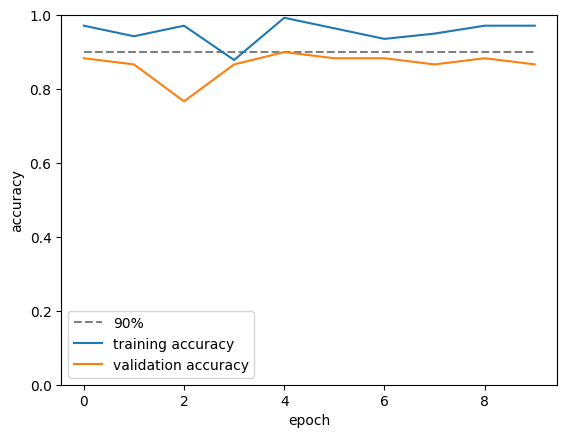

In [229]:
plt.hlines(0.9, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="90%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

We then unfreeze most of the lower layers and train further (with a reduced learning rate):

In [230]:
for layer in m_new_old_fashion.layers[8:]:
    layer.trainable = True

In [231]:
m_new_old_fashion.compile(loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
history = m_new_old_fashion.fit(X_new_fashion_train, y_new_fashion_train, 
    batch_size=128, epochs=30, validation_split=0.3, verbose=0)

(0.0, 1.0)

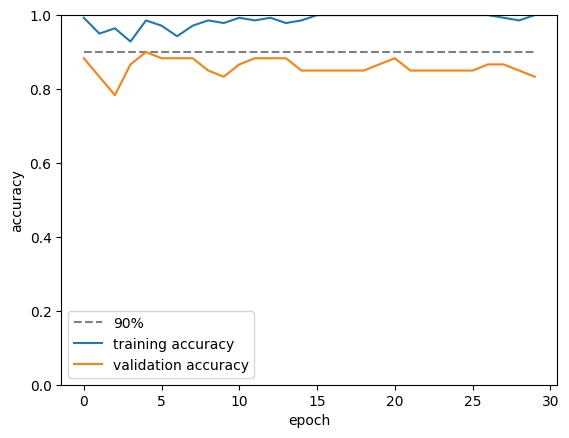

In [232]:
plt.hlines(0.9, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="90%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

With this small of a dataset it's unclear whether transfer learning is helping us, but at least this demonstrates how one might use transfer learning.

### Learning rate schedules

There are multiple ways to set up learning rate schedules. Some optimizers natively support a decay rate for power scheduling, i.e.

$$\eta_t = \eta_0 (1 + t/s)^{-c},$$

where $t$ is the iteration number and $s$ and $c$ are hyperparameters. For example:

In [233]:
optimizer = keras.optimizers.Adam(weight_decay=1e-4)

Many other optimizers are built-in in the form of callbacks:

In [234]:
scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, persistence=4)
history = m_new_old_fashion.fit(X_new_fashion_train, y_new_fashion_train,
    callbacks=[scheduler],
    batch_size=128, epochs=20, validation_split=0.3, verbose=0)

(0.0, 1.0)

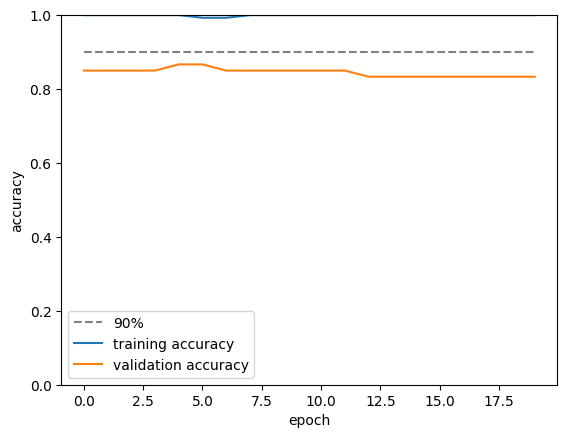

In [235]:
plt.hlines(0.9, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="90%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

The callback approach can be used to create custom callbacks:

In [236]:
def my_learning_rate(epoch):
    return 0.01 * 0.5**(epoch/8)

scheduler = keras.callbacks.LearningRateScheduler(my_learning_rate)
history = m_new_old_fashion.fit(X_new_fashion_train, y_new_fashion_train,
    callbacks=[scheduler],
    batch_size=128, epochs=2, validation_split=0.3, verbose=0)

In addition, the various optimizers will accept a learning rate schedule parameter (which updates every step, and not just at each epoch):

In [237]:
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)